# Adversarial examples in CNNs

Victor Pachy, Valentin Alleaume

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

#assert we are using tensorflow 2 
print("TensorFlow version:", tf.__version__)

# Load and preprocess the MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape the input data to be 4D (batch_size, height, width, channels)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Define the CNN architecture, same architecture as in https://www.tensorflow.org/tutorials/quickstart/advanced
# We make use of  Convolution layer in order to treat the image with not too much parameters
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 output classes (0-9)
])


# Compile the model
# We use sparse_categorical_cross_entropy because it is a classification problem
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)


TensorFlow version: 2.5.0
Epoch 1/5
844/844 [==============================] - 37s 40ms/step - loss: 0.1629 - accuracy: 0.9506 - val_loss: 0.0558 - val_accuracy: 0.9835
Epoch 2/5
844/844 [==============================] - 32s 37ms/step - loss: 0.0455 - accuracy: 0.9859 - val_loss: 0.0517 - val_accuracy: 0.9857
Epoch 3/5
844/844 [==============================] - 39s 46ms/step - loss: 0.0256 - accuracy: 0.9918 - val_loss: 0.0589 - val_accuracy: 0.9838
Epoch 4/5
844/844 [==============================] - 38s 45ms/step - loss: 0.0143 - accuracy: 0.9956 - val_loss: 0.0548 - val_accuracy: 0.9855
Epoch 5/5
844/844 [==============================] - 33s 40ms/step - loss: 0.0079 - accuracy: 0.9979 - val_loss: 0.0487 - val_accuracy: 0.9882


In [17]:
# # Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

313/313 [==============================] - 2s 8ms/step - loss: 0.0551 - accuracy: 0.9849
Test accuracy: 0.985


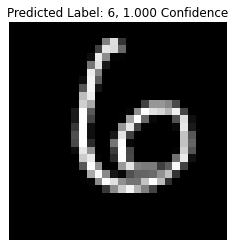

In [18]:
import matplotlib.pyplot as plt
import numpy as np


# We choose an index from the test set
index = 100

# Make predictions on the test set
predictions = model.predict(x_test)

# We get the predicted label for the chosen index
predicted_label = np.argmax(predictions[index])
confidence = np.max(predictions[index])

# Finally, we display the test image
plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
plt.title(f'Predicted Label: {predicted_label}, {confidence:.3f} Confidence')
plt.axis('off')
plt.show()


# Adversarial Example

We aim to perturbate the prediction of a model using a slight perturbation in the input. This can always be done in the linear case, provided that the dimension is big enough. Indeed, for a weight vector $w$, an input $x$, a target $y$ and a perturbation $\eta$ we have :

$$ \langle w, x+ \eta \rangle=  \langle w, x \rangle + \langle w, \eta \rangle = y + \langle w, \eta \rangle$$
The output perturbation is $\langle w, \eta \rangle$. The optimal direction to maximize this dot product under the constraint $||\eta||_{\infty} \leq cst $ is $\text{sign}(w)$.
In this case, if the dimension is $n$ and the average magnitude of the coordinates of $w$ is $m$ then the output perturbation is $\varepsilon m n$, where $ \varepsilon = ||\eta||_{\infty}$.

_Curse of dimensionnality_ : This perturbation grows with the dimension $n$ even if $\varepsilon$ is fixed. With large dimensionnal input (such as images) we can make large perturbation of the output and change the output by adding an imperceptible noise $\eta$ with a well-chosen direction.

### Non-linear case : 
In the non-linear case there are activation functions inside the network, we consider that those functions and the resulting network are "too linear". This is especially true for ReLu activation function and the network we considered in this example (only 2 hidden layers). Therefore, linearizing the model and using the same technique should create acceptable adversarial input. For a given set of parameter $\theta$ of the model, the cost $J(\theta, x, y)$ can be approximated by $\langle \nabla_x J(\theta, x, y) , x \rangle$ and we are back to the linear case with $w = \nabla_x J(\theta, x, y)$

In [19]:
def compute_input_gradient(model, input_image, class_index=0):
    # Ensure the input image is in a TensorFlow Tensor format
    input_image = tf.convert_to_tensor(input_image)
    input_image = tf.expand_dims(input_image, axis=0)  # Add a batch dimension
    
    with tf.GradientTape() as tape:    
        tape.watch(input_image)  # Keppe a trace of operations
        predictions = model(input_image)
        
        # Get the predicted probability for the specified class
        predicted_prob = predictions[0, class_index]
    
    # Compute the gradient of the probability with respect to the input image
    input_gradient = tape.gradient(predicted_prob, input_image)
    
    # Squeeze out the batch dimension
    input_gradient = tf.squeeze(input_gradient, axis=0)
    
    return input_gradient.numpy()  # Convert to NumPy array for easier manipulation

# Example usage:
# model: Your trained TensorFlow/Keras model
# input_image: The input image for which you want to compute the gradient
input_image = x_test[index]

# Compute the gradient
gradient = compute_input_gradient(model, input_image, class_index=1)


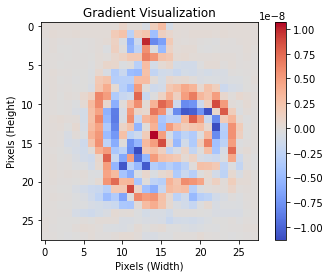

In [20]:
import matplotlib.pyplot as plt

# Assume gradient contains the gradient values in NumPy array format

# Plot the gradient
plt.imshow(gradient, cmap='coolwarm')
plt.colorbar()
plt.title('Gradient Visualization')
plt.xlabel('Pixels (Width)')
plt.ylabel('Pixels (Height)')
plt.show()


In [21]:
epsilon = 0.2  # Hyperparameter (small value)

reshaped_gradient = tf.reshape(gradient, input_image.shape)

# Add the sign of the gradient to the input image + a small epsilon value
adversarial_image = input_image + tf.sign(reshaped_gradient) * epsilon

# Clip the values of the adversarial image to be within the valid range (0, 1)
adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)

# Convert the adversarial image to NumPy array for visualization
adversarial_image_np = adversarial_image.numpy()
adversarial_image_np = np.reshape(adversarial_image_np, (1, 28, 28, 1))

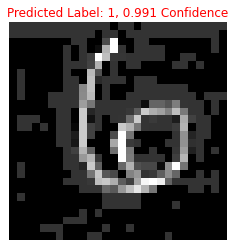

In [22]:
# Convert the adversarial image to Tensor in order to get the metric
adversarial_image_tensor = tf.convert_to_tensor(adversarial_image_np)

# Make predictions using the trained model
predictions = model(adversarial_image_tensor)

# Get the predicted label and confidence
predicted_label = np.argmax(predictions)
confidence = np.max(predictions)

# Display the adversarial image
plt.imshow(adversarial_image_np.reshape(28, 28), cmap='gray')
plt.axis('off')


# Display the predicted label and confidence above the image
plt.title(f'Predicted Label: {predicted_label}, {confidence:.3f} Confidence', fontsize=12, color='red')

# Show the image with the predicted label
plt.show()

In [23]:
def generate_adversarial_image(model, input_image, target_class, epsilon = 0.2):
    
    """ Functions that encapsulate the previous cell in order to generate an adversarial image for a given model and target class. 
    This adversarial_image is a perturbation of input image : each pixel is changed at most by a quantity of epsilon.
    
    model : tensorflow model, callable
    input_image : tensorflow Tensor
    target_class : integer in [0,9]
    epsilon : float in [0,1]"""

    
    #compute the gradient of the target_class probability relatively to the input image
    gradient = compute_input_gradient(model, input_image, class_index=target_class)
    reshaped_gradient = tf.reshape(gradient, input_image.shape)

    # Add the sign of the gradient to the input image + a small epsilon value
    adversarial_image = input_image + tf.sign(reshaped_gradient) * epsilon

    # Clip the values of the adversarial image to be within the valid range (0, 1)
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)

    # Convert the adversarial image to NumPy array 
    adversarial_image_np = adversarial_image.numpy()
    adversarial_image_np = np.reshape(adversarial_image_np, (1, 28, 28, 1))
    return adversarial_image_np
        

In [24]:
def display_images(image_np, description, model):

  """ Method that print inline in the notebook the given image alongside its predicted label and confidence by the given model.

  input_np : image as a np.array 
  description : string to add to the title of the figure
  model : tensorflow model, callable
  """

  image_tensor = tf.convert_to_tensor(image_np)
  predictions = model(image_tensor)

  # Get the predicted label
  predicted_label = np.argmax(predictions)
  confidence = np.max(predictions)

  plt.figure()
  plt.imshow(image_np.reshape(28, 28), cmap='gray')
  plt.axis('off')
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   predicted_label, confidence*100))

## Influence of different parameter over the effectiveness of the attack

The effectiveness of the adversarial example depends on the amplitude of the noise $\epsilon$

In [29]:
# Define a list of different noise amplitude and their corresponding title
epsilons = [0, 0.01, 0.1, 0.15, 0.2, 0.35, 0.5]
descriptions = [('Epsilon = {:0.2f}'.format(eps) if eps else 'Input')
                for eps in epsilons]


In [ ]:
# Iterates over the different noises amplitude
for i, eps in enumerate(epsilons):
  adversarial_image = generate_adversarial_image(model, input_image, target_class = 8, epsilon = epsilons[i])
  display_images(adversarial_image, descriptions[i], model)

The effectiveness of the adversarial example depends on the target class $k$ and the norm 1 of its associated gradient $w_k = \nabla_x J_k$

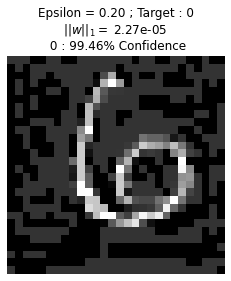

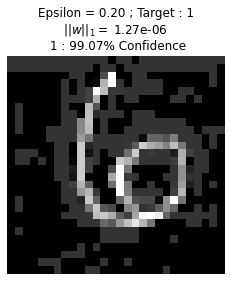

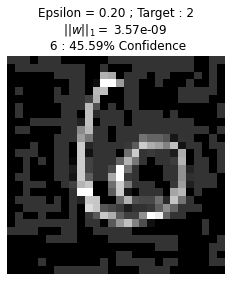

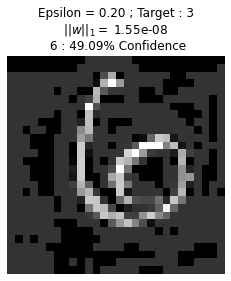

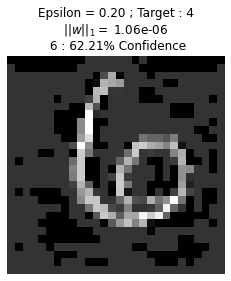

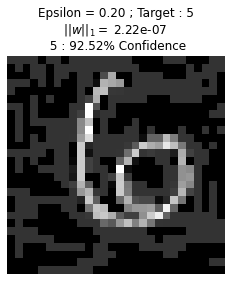

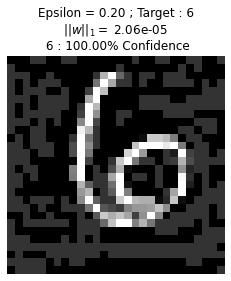

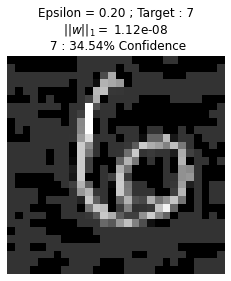

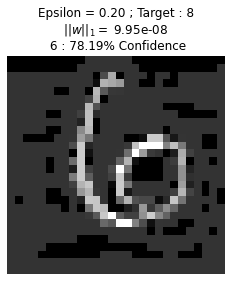

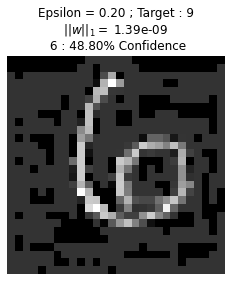

In [26]:
#Search for the worst class
for target_class in range(10):
  adversarial_image = generate_adversarial_image(model, input_image, target_class = target_class)
  gradient = compute_input_gradient(model, input_image, target_class)
  norm = np.sum(np.abs(gradient))
  display_images(adversarial_image, descriptions[4] + f' ; Target : {target_class}' + '\n' + f'$||w||_1 =$ {norm:.3}', model)


The effectiveness of the adversarial example depends on the input image and its associated confidence : if $y$ is small then a rather small perturbation can change easily the output.

1709


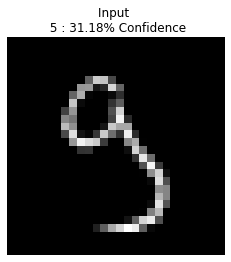

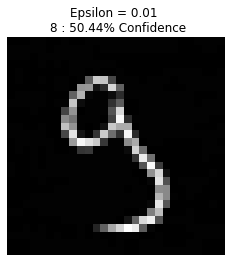

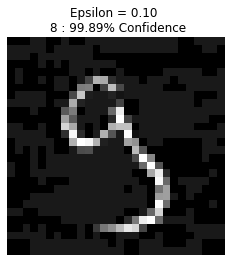

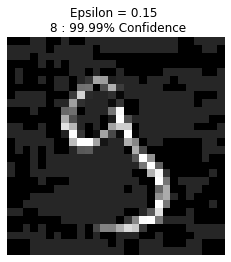

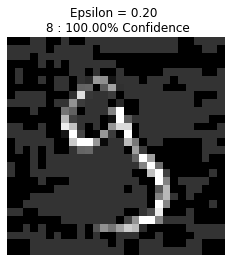

In [27]:
#search for the worst confidence 
i_worse = np.argmin(np.max(model(x_test),axis = 1))
print(i_worse)
new_input_image = x_test[i_worse]

for i, eps in enumerate(epsilons[:5]):
  adversarial_image = generate_adversarial_image(model, new_input_image, target_class = 8, epsilon = epsilons[i])
  display_images(adversarial_image, descriptions[i], model)

## Systematic approach
### Random target

In [28]:
import random as random

#define hyperparameters
n = 1200
eps = 0.2
error_rate = 0

#draw a random sample to make statistics
sample = random.sample(list(range(10000)), n)

#baseline 
ground_truth = y_test[sample]
output = np.argmax(model(x_test[sample]), axis = 1)
mask = np.equal(output, ground_truth)
baseline = np.count_nonzero(mask)/n
print(f'The success rate of the model on the random sample drawn from x_test is {100*baseline:.2f}%. \n The sample contains {n} elements')

#iterate over the sucesses of the model
for i in np.array(sample)[mask]:
    
    #draw a random target, different from the ground truth
    target = random.sample( [k for k in range(10) if k != y_test[i]], 1)[0]

    #generate an adversarial image along this direction and check if it fooled the network
    adversarial_image = tf.convert_to_tensor(generate_adversarial_image(model, x_test[i], target_class = target, epsilon = eps))
    predicted_label = np.argmax(model(adversarial_image))
    if predicted_label != y_test[i]:
        error_rate += 1
error_rate /= (baseline*n)
print( f'Using a noise of maximum amplitude epsilon = {eps} the model is fooled {100*error_rate:.2f}% of the time ')


The success rate of the model on the random sample drawn from x_test is 98.42%. 
 The sample contains 1200 elements
Using a noise of maximum amplitude epsilon = 0.2 the model is fooled 83.91% of the time 


### Worse target

In [14]:
#define hyperparameters
n = 1200
eps = 0.2
error_rate = 0

#draw a random sample to make statistics
sample = random.sample(list(range(10000)), n)

#baseline 
ground_truth = y_test[sample]
output = np.argmax(model(x_test[sample]), axis = 1)
mask = np.equal(output, ground_truth)
baseline = np.count_nonzero(mask)/n
print(f'The success rate of the model on the random sample drawn from x_test is {100*baseline:.2f}%. \n The sample contains {n} elements')

#iterate over the sucesses of the model
for i in np.array(sample)[mask]:
    
    #pick the worse target class
    norm_max = 0
    target = 0 
    for target_class in [k for k in range(10) if k != y_test[i]] :
        gradient = compute_input_gradient(model, x_test[i], target_class)
        norm = np.sum(np.abs(gradient))
        if norm_max < norm:
            norm_max = norm
            target = target_class

    #generate an adversarial image along this direction and check if it fooled the network
    adversarial_image = tf.convert_to_tensor(generate_adversarial_image(model, x_test[i], target_class = target, epsilon = eps))
    predicted_label = np.argmax(model(adversarial_image))
    if predicted_label != y_test[i]:
        error_rate += 1
error_rate /= (baseline*n)
print( f'Using a noise of maximum amplitude epsilon = {eps} the model is fooled {100*error_rate:.2f}% of the time ')

The success rate of the model on the random sample drawn from x_test is 98.92%. 
 The sample contains 1200 elements
Using a noise of maximum amplitude epsilon = 0.2 the model is fooled 97.73% of the time 


## To go further : Generalization of adversarial images accross multiple models

As explained in section 8 of "Harnessing Adversarial Examples" [1] , adversarial example can generalize accross multiple model.

In [15]:
#more complex model
model2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 output classes (0-9)
])

# Compile the model
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model2.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# # Evaluate the model on the test set
test_loss, test_acc = model2.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Epoch 1/5
844/844 [==============================] - 35s 41ms/step - loss: 0.2054 - accuracy: 0.9362 - val_loss: 0.0585 - val_accuracy: 0.9835
Epoch 2/5
844/844 [==============================] - 34s 40ms/step - loss: 0.0532 - accuracy: 0.9839 - val_loss: 0.0377 - val_accuracy: 0.9882
Epoch 3/5
844/844 [==============================] - 39s 46ms/step - loss: 0.0381 - accuracy: 0.9878 - val_loss: 0.0299 - val_accuracy: 0.9910
Epoch 4/5
844/844 [==============================] - 34s 41ms/step - loss: 0.0294 - accuracy: 0.9906 - val_loss: 0.0318 - val_accuracy: 0.9917
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.0287 - accuracy: 0.9910
Test accuracy: 0.991


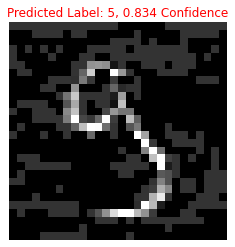

In [34]:
# we pick the worst image of the first model

new_input_image = x_test[i_worse]

# Wepick the worst target class for this image
norm_max = 0
target = 0 
for target_class in [k for k in range(10) if k != y_test[i_worse]] :
    gradient = compute_input_gradient(model, new_input_image, target_class)
    norm = np.sum(np.abs(gradient))
    if norm_max < norm:
        norm_max = norm
        target = target_class

#generate an adversarial image using the gradient of the simple model network
adv = generate_adversarial_image(model, new_input_image, target, epsilon = 0.2)
adversarial_image_tensor = tf.convert_to_tensor(adv)

# Make predictions using the complex model
predictions = model2(adversarial_image_tensor)

# Get the predicted label
predicted_label = np.argmax(predictions)
confidence = np.max(predictions)

# Display the adversarial image
plt.imshow(adv.reshape(28, 28), cmap='gray')
plt.axis('off')


# Print the predicted label above the image
plt.title(f'Predicted Label: {predicted_label}, {confidence:.3f} Confidence', fontsize=12, color='red')

# Show the image with the predicted label
plt.show()

# Sources

The main article explaining how this attack works : "J. Goodfellow, Jonathon Shlens, and Christian Szegedy. Explaining and Harnessing Adversarial Examples, 2015. arxiv: 1412.6572" [1] https://arxiv.org/abs/1412.6572

A notebook showing how to correctly classify the MNIST database using CNN https://www.tensorflow.org/tutorials/quickstart/advanced

Example of the implementation of a FGSM attack on another dataset 
https://www.tensorflow.org/tutorials/generative/adversarial_fgsm